In [35]:
%pip install tensorflow-hub tensorflow-docs

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 10.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches


from IPython.display import HTML, display

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  # Some modules to display an animation using imageio.
  import imageio
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [38]:
import tensorflow_hub as tfhub


In [2]:
module = tfhub.load('https://tfhub.dev/google/movenet/singlepose/thunder/4')
module

2023-11-15 00:19:49.069718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 00:19:49.088287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 00:19:49.088454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f57b84a2750>

In [3]:
type(module)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

In [9]:
import tensorflow_datasets_ee6222har.ee6222har as tfds_ee6222har

ds_builder = tfds_ee6222har.builder.Builder()
ds_builder.download_and_prepare()
ds = ds_builder.as_dataset(as_supervised=False)

In [7]:
take_one = lambda x: next(iter(x))


In [15]:
image = take_one(ds['train'])['frameseq'][0]

In [17]:
movenet = module.signatures['serving_default']

In [52]:
movenet

<ConcreteFunction signature_wrapper(*, input) at 0x7F597FC21ED0>

In [27]:
n_batches, *frame_size, n_channels = movenet.inputs[0].shape

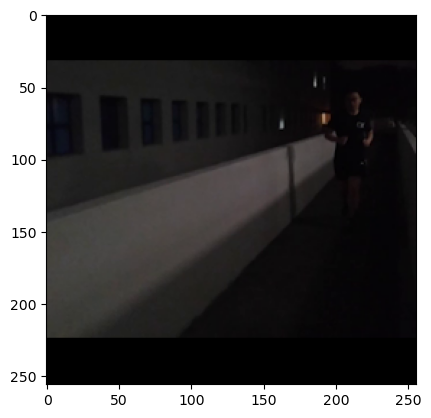

In [33]:
import tensorflow as tf

import matplotlib.pyplot as plt

plt.imshow(
tf.cast(
tf.image.resize_with_pad(
    image,
    *frame_size
),
    tf.uint8
    
)

)

In [48]:
image_resized = tf.image.resize_with_pad(
    image,
    *frame_size
)

input_image = tf.cast(image_resized, dtype=tf.int32)
input_image = tf.expand_dims(input_image, axis=0)
keypoints_with_scores = movenet(
     input_image
)['output_0']

In [49]:
keypoints_with_scores

<tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.24397783, 0.83099115, 0.33633837],
         [0.23842613, 0.8391465 , 0.43971932],
         [0.23988742, 0.8262133 , 0.44367042],
         [0.24059707, 0.84825236, 0.4870817 ],
         [0.24474493, 0.8140048 , 0.49614638],
         [0.28022593, 0.86800796, 0.34882724],
         [0.28061587, 0.79896927, 0.38357952],
         [0.32993218, 0.88293856, 0.29511335],
         [0.32698882, 0.78082687, 0.2957187 ],
         [0.35995027, 0.8715684 , 0.2274574 ],
         [0.3355634 , 0.78305894, 0.2886324 ],
         [0.39426917, 0.8532338 , 0.48796645],
         [0.395396  , 0.8142071 , 0.4482478 ],
         [0.46923193, 0.8477562 , 0.29536495],
         [0.46690717, 0.81708556, 0.45689338],
         [0.54120713, 0.85212874, 0.28393033],
         [0.5366094 , 0.82224655, 0.35327807]]]], dtype=float32)>

/tmp/ipykernel_3090012/2643716296.py:174: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


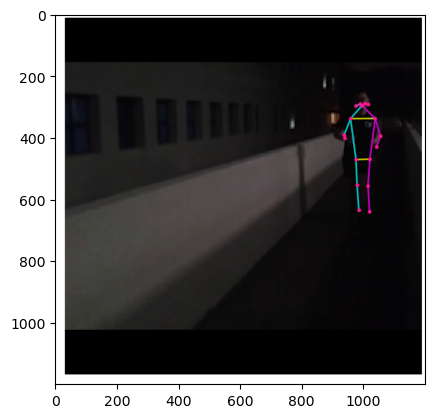

In [51]:
plt.imshow(
    
draw_prediction_on_image(
    np.squeeze(input_image.numpy(), axis=0), keypoints_with_scores)

)

In [42]:
input_image.shape

TensorShape([256, 256, 3])

In [69]:
class MoveNet(tf.keras.Model):
    @classmethod
    def from_hub(cls, variant):
        base_url = 'https://tfhub.dev/google/movenet/singlepose'
        variant_url = {
            'lightning': rf'{base_url}/lightning/4',
            'thunder': rf'{base_url}/thunder/4',
        }
        module = tfhub.load(variant_url.get(variant, 'lightning'))
        return cls(module)

    # TODO NOTE saved_model: tensorflow saved model
    def __init__(self, saved_model):
        super().__init__()
        self.base = saved_model.signatures['serving_default']

    def call(self, inputs):
        print('TODO rm inputs.shape', inputs.shape)
        _n_batches, *input_frame_size, _n_channels = (
            self.base.inputs[0].shape
        )
        inputs = tf.image.resize_with_pad(
            inputs,
            *input_frame_size
        )
        inputs = tf.cast(inputs, dtype=tf.int32)
        # TODO NOTE movenet's batch processing is dysfunctional
        print('- TODO rm inputs.shape', inputs.shape)
        inputs = tf.reshape(inputs, self.base.inputs[0].shape)
        return self.base(inputs)['output_0']


In [70]:
# TODO
#MoveNet.from_hub('thunder')

In [73]:
from tensorflow import keras
testaaa = keras.layers.TimeDistributed(
    (
        MoveNet(module)
    )
)

In [75]:
testaaa((ds['train']).ragged_batch(1).map(lambda x: x['frameseq']))

TypeError: Inputs to a layer should be tensors. Got '<_MapDataset element_spec=RaggedTensorSpec(TensorShape([None, None, None, None, 3]), tf.uint8, 3, tf.int64)>' (of type <class 'tensorflow.python.data.ops.map_op._MapDataset'>) as input for layer 'time_distributed_4'.

In [65]:
MoveNet(module)(take_one(ds['train'])['frameseq'][0])

(256, 256, 3)


<tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.24397783, 0.83099115, 0.33633837],
         [0.23842613, 0.8391465 , 0.43971932],
         [0.23988742, 0.8262133 , 0.44367042],
         [0.24059707, 0.84825236, 0.4870817 ],
         [0.24474493, 0.8140048 , 0.49614638],
         [0.28022593, 0.86800796, 0.34882724],
         [0.28061587, 0.79896927, 0.38357952],
         [0.32993218, 0.88293856, 0.29511335],
         [0.32698882, 0.78082687, 0.2957187 ],
         [0.35995027, 0.8715684 , 0.2274574 ],
         [0.3355634 , 0.78305894, 0.2886324 ],
         [0.39426917, 0.8532338 , 0.48796645],
         [0.395396  , 0.8142071 , 0.4482478 ],
         [0.46923193, 0.8477562 , 0.29536495],
         [0.46690717, 0.81708556, 0.45689338],
         [0.54120713, 0.85212874, 0.28393033],
         [0.5366094 , 0.82224655, 0.35327807]]]], dtype=float32)>

In [53]:
tf.SavedModel

AttributeError: module 'tensorflow' has no attribute 'SavedModel'